In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess
import shutil
import time
from nilearn import datasets
from nilearn.image import load_img, index_img
from nilearn.plotting import plot_epi
from nilearn.maskers import NiftiLabelsMasker
# from PyIF import te_compute as te
from joblib import delayed, Parallel
import pandas as pd
from scipy.stats import zscore
from scipy.optimize import curve_fit
from joblib import Parallel, delayed
import glob
from utils.data_loader import DataLoader
from utils.plotting import plot_voxels, plot_w_fit
import scipy.stats as stats
# import seaborn as sns

In [2]:
root_dir = '/scratch/shivansh.seth/adni/preproc'
SCRATCH_DATA_DIR = '/scratch/shivansh.seth/tmp/'
PRINT_TIME_INTERVAL = 20
if not os.path.exists(SCRATCH_DATA_DIR): os.makedirs(SCRATCH_DATA_DIR)

In [3]:
# For func output
dloader = DataLoader(root_dir)
subjects_list = dloader.subjects_list
len(dloader.subjects_list)

89

In [4]:
rts_res_dir = '/home/shivansh.seth/phase_diagram_analysis/rts_results'
rts_fl = []
for sub in dloader.subjects_list:
    for j in os.listdir(rts_res_dir):
        if sub in j:
            rts_fl.append(os.path.join('rts_results', j))

In [15]:
rts_results= np.memmap(
        os.path.join(SCRATCH_DATA_DIR, 'roi_rts.dat'), 
        dtype='float32', 
        mode='w+', 
        shape=(len(dloader.subjects_list), *dloader.get_func(0).shape[:-1], 5)
    )
for idx, i in enumerate(rts_fl):
    rts = np.load(i)
    rts_results[idx] = rts
    del rts

In [16]:
og_shape_rts = rts_results.shape
rts_results_flat = rts_results.reshape(og_shape_rts[0], -1, 5)
og_shape = og_shape_rts[1: -1]
## Replacing inf with nan for np.nan* functions
rts_results_flat[rts_results_flat==np.inf] = np.nan

In [17]:
roi_rts_rmse = rts_results_flat[:, :, 3]
roi_rts_se = rts_results_flat[:, :, 4]
roi_rts_taus = rts_results_flat[:, :, 0]

In [18]:

def get_accepted_ranges(rrts):
    accepted_ranges = []
    q1, q3 = np.nanpercentile(rrts, [25, 75], axis=0)

    # Calculate IQR
    iqr = q3 - q1

    # Calculate lower and upper bounds
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    accepted_ranges = np.array((lower_bound, upper_bound))

    return accepted_ranges.T

def get_outliers(rrts, sub_idxs=None):
    accepted_ranges = get_accepted_ranges(rrts)
    outliers = []
    for i in range(rrts.shape[1]):
        rejected_subs = np.where( (rrts[:, i] < accepted_ranges[i][0]) | (rrts[:, i] > accepted_ranges[i][1]) )[0]
        nan_subs = np.where(np.isnan(rrts[:, i]))[0]
        outliers.append(list(set(list(rejected_subs) + list(nan_subs))))
    
    # Popping elements not included in subject list without 
    # disturbing original indices
    if not (type(sub_idxs) == type(None)):
        for roi_ind in range(len(outliers)):
            non_sub_idx_outliers = []
            outliers[roi_ind] = list(outliers[roi_ind])

            for i in range(len(outliers[roi_ind])):
                if outliers[roi_ind][i] not in sub_idxs:
                    non_sub_idx_outliers.append(i)
            for i in sorted(non_sub_idx_outliers, reverse=True):
                del outliers[roi_ind][i]

    return outliers

In [10]:
accepted_ranges = get_accepted_ranges(roi_rts_taus)

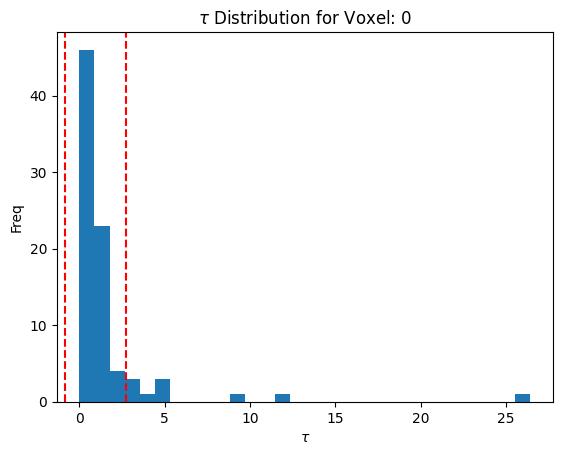

NameError: name 'rrts' is not defined

In [12]:
# roi_idx = 164109 # high tau idx
roi_idx = 0
plt.hist(roi_rts_taus[:, roi_idx], bins=30)
plt.axvline(accepted_ranges[roi_idx, 0], color='r', linestyle='--')
plt.axvline(accepted_ranges[roi_idx, 1], color='r', linestyle='--')
plt.xlabel('$\\tau$')
plt.ylabel('Freq')
plt.title(f'$\\tau$ Distribution for Voxel: {roi_idx}')
plt.show()
n_outliers = np.sum(roi_rts_taus[:, roi_idx] > accepted_ranges[roi_idx, 1]) + \
             np.sum(roi_rts_taus[:, roi_idx] < accepted_ranges[roi_idx, 0])
print('Number of outliers:', n_outliers)

In [10]:
def fix_outliers(inp_rrts, outliers):
    '''
    Outputs array after setting all outliers and all NaNs to the mean values
    '''
    rrts = np.array(inp_rrts)
    
    for i in range(rrts.shape[1]):
        rrts[outliers[i], i] = np.nan
#     for i in range(rrts.shape[1]):
#         rrts[np.isnan(rrts[:, i]), i] = np.nanmean(rrts[:, i])
    return rrts

In [11]:
cn_roi_rts = np.array([ roi_rts_taus[i] for i in range(roi_rts_taus.shape[0]) if dloader.diag[i] == 0 ])
ad_roi_rts = np.array([ roi_rts_taus[i] for i in range(roi_rts_taus.shape[0]) if dloader.diag[i] == 1 ])

## P value calculation

In [16]:
# t_stat, p_value = [], []
# s1_rts_mean, s2_rts_mean = [], []
# s1_n_outliers, s2_n_outliers = [], []
# for roi_idx in range(s1_rts.shape[1]):
#     # counting outliers
#     s1_n_outliers.append(np.sum(~np.isnan(s1_rts[:, roi_idx])))
#     s2_n_outliers.append(np.sum(~np.isnan(s2_rts[:, roi_idx])))
    
#     # removing all nan values
#     s1_roi = s1_rts[:, roi_idx]
#     s2_roi = s2_rts[:, roi_idx]
#     s1_roi = s1_roi[~np.isnan(s1_roi)]    
#     s2_roi = s2_roi[~np.isnan(s2_roi)]
    
#     # mean without nans (can use np.nanmean directly)
#     s1_rts_mean.append(np.mean(s1_roi))    
#     s2_rts_mean.append(np.mean(s2_roi))
    
#     # t-test for roi
#     t, p = stats.ttest_ind(s1_roi, s2_roi)
#     t_stat.append(t), p_value.append(p)
    
#     if roi_idx%10000 == 0:
#         print(roi_idx, end=" ", flush=True)

# s1_rts_mean = np.array(s1_rts_mean)
# s2_rts_mean = np.array(s2_rts_mean)

# p_value = np.array(p_value)
# t_stat = np.array(t_stat)

# # Print the results
# print("t-statistic: ", t_stat)
# print("p-value: ", p_value)
# p_value.shape, t_stat.shape

0 10000 20000 30000 40000 50000 60000 70000 80000 90000 100000 110000 120000 130000 140000 150000 160000 170000 180000 190000 200000 210000 220000 t-statistic:  [2.38831771 2.35755533 2.35465721 ... 2.38810169 2.38810169 2.38810169]
p-value:  [0.02365687 0.02535631 0.02552202 ... 0.02366844 0.02366844 0.02366844]


((228939,), (228939,))

In [13]:
def calc_p_value(s1, s2):

    s1_outliers = get_outliers(s1)
    s2_outliers = get_outliers(s2)
    s1_rts = fix_outliers(s1, s1_outliers)
    s2_rts = fix_outliers(s2, s2_outliers)

#     s = np.vstack((s1, s2)).shape
#     s1_idx = len(s1)
#     s_outliers = get_outliers(s)
#     s_rts = fix_outlier(s, s_outliers)
#     s1_rts = s[:s1_idx]
#     s2_rts = s[s1_idx:]
    
    t_stat, p_value = [], []
    s1_rts_mean, s2_rts_mean = [], []
    s1_n_outliers, s2_n_outliers = [], []
    for roi_idx in range(s1_rts.shape[1]):
        # counting outliers
        s1_n_outliers.append(np.sum(~np.isnan(s1_rts[:, roi_idx])))
        s2_n_outliers.append(np.sum(~np.isnan(s2_rts[:, roi_idx])))

        # removing all nan values
        s1_roi = s1_rts[:, roi_idx]
        s2_roi = s2_rts[:, roi_idx]
        s1_roi = s1_roi[~np.isnan(s1_roi)]    
        s2_roi = s2_roi[~np.isnan(s2_roi)]

        # mean without nans (can use np.nanmean directly)
        s1_rts_mean.append(np.mean(s1_roi))    
        s2_rts_mean.append(np.mean(s2_roi))

        # t-test for roi
        t, p = stats.ttest_ind(s1_roi, s2_roi)
        t_stat.append(t), p_value.append(p)

        if roi_idx%10000 == 0:
            print(roi_idx, end=" ", flush=True)

    s1_rts_mean = np.array(s1_rts_mean)
    s2_rts_mean = np.array(s2_rts_mean)

    p_value = np.array(p_value)
    t_stat = np.array(t_stat)
    return p_value, t_stat, s1_rts_mean, s2_rts_mean

In [19]:
cn_roi_rts = np.array([ roi_rts_taus[i] for i in range(roi_rts_taus.shape[0]) if dloader.diag[i] == 0 ])
cn_subs = [dloader.subjects_list[i] for i in range(roi_rts_taus.shape[0]) if dloader.diag[i] == 0]
ad_roi_rts = np.array([ roi_rts_taus[i] for i in range(roi_rts_taus.shape[0]) if dloader.diag[i] == 1 ])
ad_subs = [dloader.subjects_list[i] for i in range(roi_rts_taus.shape[0]) if dloader.diag[i] == 1]

In [32]:
print(s1.shape, s2.shape)


(17, 228939) (17, 228939)


(34, 228939)

In [20]:
trials = 1
p_vals = []
t_stats = []
s1_means, s2_means = [], []
sig_rois = []
for i in range(trials):
    indices = np.random.permutation(len(cn_roi_rts))
    split_idx = int(len(cn_roi_rts) * 0.5) # splitting the array in half
    s1 = cn_roi_rts[indices[:split_idx]]
    s2 = cn_roi_rts[indices[split_idx:]]
    p_value, t_stat, s1_rts_mean, s2_rts_mean = calc_p_value(s1, s2)
    p_vals.append(p_value)
    t_stats.append(t_stat)
    s1_means.append(s1_rts_mean)
    s2_means.append(s2_rts_mean)
    sig_rois.append(len(list(np.where(p_value<0.05)[0])))

NameError: name 'fix_outliers' is not defined

In [ ]:
s1_means = np.array(s1_means)
s2_means = np.array(s2_means)
s1_rts_mean = np.mean(s1_means, axis=0)
s2_rts_mean = np.mean(s2_means, axis=0)

In [ ]:
for i in range(trials):
    plt.hist(s1_means[i], label='Split1', alpha=1, bins=50)
    plt.hist(s2_means[i], label='Split2', alpha=0.3, bins=50)
    plt.legend()
    plt.xlabel("$<\\tau>$")
    plt.ylabel("$n_{ROI}$")
    plt.show()

In [29]:
sig_rois

[20869, 36489, 22260, 25635, 31266]

In [28]:
np.mean(sig_rois), np.std(sig_rois)

(27303.8, 5825.777043450942)

In [14]:
s1_rts = fix_outliers(s1, s1_outliers)
s2_rts = fix_outliers(s2, s2_outliers)

In [15]:
s1_rts.shape, s2_rts.shape

((17, 228939), (17, 228939))

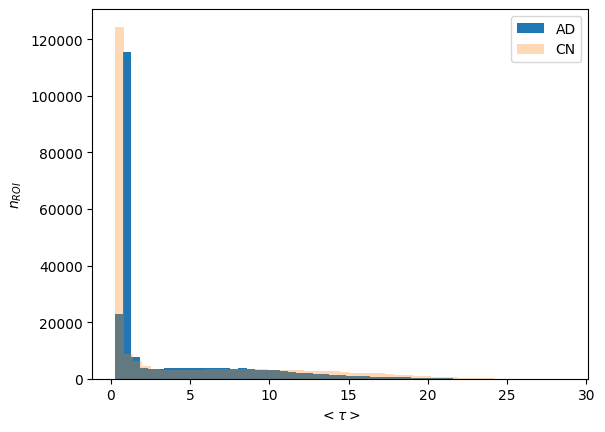

In [17]:
plt.hist(s1_rts_mean, label='AD', alpha=1, bins=50)
plt.hist(s2_rts_mean, label='CN', alpha=0.3, bins=50)
plt.legend()
plt.xlabel("$<\\tau>$")
plt.ylabel("$n_{ROI}$")
plt.show()

In [18]:
sig_rois = list(np.where(p_value<0.05)[0])
print("Significant RoIs:", len(sig_rois))

Significant RoIs: 114926


In [ ]:
from matplotlib.patches import Patch

fig, ax = plt.subplots()

roi_start, roi_end = 1000, 1020
bp1 = ax.boxplot(cn_roi_rts[:, sig_rois[:20]], patch_artist=True)
# bp1 = ax.boxplot(np.array(rrts[:, roi_start:roi_end]), patch_artist=True)
# bp1 = ax.boxplot(np.array(cn_roi_rts[:, roi_start:roi_end]), patch_artist=True)
roi_start:roi_end

box_colors = ['red',]
median_colors = ['blue', ]
for bplot, box_color, median_color in zip([bp1,], box_colors, median_colors):
    # change box color
    for patch in bplot['boxes']:
        patch.set_facecolor(box_color)
    # change median color
    for line in bplot['medians']:
        line.set_color(median_color)
        
color_patches = [ Patch(facecolor=box_colors[0], label=f'All'), ]
ax.legend(handles=color_patches)
fig.set_size_inches(15, 5)
# plt.ylim(0, 10)

plt.show()